# Weekly Commodity Time Series Momentum Strategy

Strategia settimanale che sfrutta l'esplosività delle commodities tramite time series momentum (solo long) + risk parity.

## Approccio:
- **Weekly rebalancing**: Ogni lunedì 
- **Time series momentum**: 1-week lookback
- **No lookahead bias**: Lunedì t usa segnali calcolati su settimana t-1
- **Solo posizioni long** quando momentum > 0
- **Risk parity weighting** (4-week lookback per volatilità)
- **Confronto** con benchmark equal-weight commodities

## Vantaggi della frequenza settimanale:
- Maggiore reattività alle esplosività delle commodities
- Cattura meglio i movimenti violenti e rapidi
- Riduce l'impatto di outlier mensili

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from momentum_strategy import (
    load_commodities_data,
    calculate_weekly_returns,
    calculate_weekly_momentum_signals,
    calculate_weekly_risk_parity_weights,
    backtest_weekly_strategy,
    calculate_performance_metrics
)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
print("✅ Setup completato - Weekly Strategy")

✅ Setup completato - Weekly Strategy


In [2]:
# Caricamento dati commodities
print("📊 Caricamento commodities...")
commodities_prices = load_commodities_data('../data/commodities')
print(f"Shape: {commodities_prices.shape}")
print(f"Commodities: {list(commodities_prices.columns)}")
print(f"Date range: {commodities_prices.index.min()} to {commodities_prices.index.max()}")

📊 Caricamento commodities...
Shape: (6457, 12)
Commodities: ['KC_F', 'ZW_F', 'HG_F', 'ZC_F', 'NG_F', 'SB_F', 'SI_F', 'CT_F', 'ZS_F', 'CL_F', 'GC_F', 'BZ_F']
Date range: 2000-01-03 00:00:00 to 2025-08-15 00:00:00


In [3]:
# Calcolo rendimenti settimanali
print("🔄 Calcolo rendimenti settimanali...")
weekly_returns = calculate_weekly_returns(commodities_prices)
print(f"Weekly returns shape: {weekly_returns.shape}")

# Rimuovi commodities con dati insufficienti (min 3 mesi = 12 settimane)
min_observations = 12
valid_commodities = weekly_returns.columns[weekly_returns.count() >= min_observations]
weekly_returns = weekly_returns[valid_commodities]
print(f"Valid commodities after filtering: {len(valid_commodities)}")
print(f"Date range: {weekly_returns.index.min()} to {weekly_returns.index.max()}")

🔄 Calcolo rendimenti settimanali...
Weekly returns shape: (1338, 12)
Valid commodities after filtering: 12
Date range: 2000-01-03 00:00:00 to 2025-08-18 00:00:00


In [4]:
# Weekly Time Series Momentum Strategy (Long Only)
lookback_weeks = 1  # 1 settimana lookback

print(f"🚀 Weekly Time Series Momentum - {lookback_weeks} week lookback")
momentum_signals = calculate_weekly_momentum_signals(weekly_returns, lookback_weeks)

# Long only: solo posizioni quando momentum > 0
long_only_signals = momentum_signals.where(momentum_signals > 0, 0)

print(f"Momentum signals shape: {momentum_signals.shape}")
print(f"Average positive momentum signals per week: {(long_only_signals > 0).sum(axis=1).mean():.1f}")
print(f"No-lookahead: Lunedì t usa segnali calcolati su settimana t-1")

🚀 Weekly Time Series Momentum - 1 week lookback
Momentum signals shape: (1338, 12)
Average positive momentum signals per week: 5.9
No-lookahead: Lunedì t usa segnali calcolati su settimana t-1


In [5]:
# Weekly Risk Parity Weighting su commodities con momentum positivo
def calculate_weekly_long_only_risk_parity_weights(momentum_signals, weekly_returns):
    """Calculate risk parity weights only for commodities with positive momentum - weekly version."""
    weights = pd.DataFrame(0.0, index=momentum_signals.index, columns=momentum_signals.columns)
    
    for date in momentum_signals.index:
        # Selezione commodities con momentum positivo
        positive_momentum = momentum_signals.loc[date]
        selected_assets = positive_momentum[positive_momentum > 0].index
        
        if len(selected_assets) > 0:
            # Weekly risk parity weighting (4 weeks lookback)
            rp_weights = calculate_weekly_risk_parity_weights(selected_assets, weekly_returns, date, lookback_weeks=4)
            weights.loc[date, selected_assets] = rp_weights
    
    return weights

print("⚖️ Calcolo weekly risk parity weights (long only)...")
strategy_weights = calculate_weekly_long_only_risk_parity_weights(momentum_signals, weekly_returns)
print(f"Average portfolio weight per commodity: {strategy_weights.mean().mean():.3f}")
print(f"Average number of positions: {(strategy_weights > 0).sum(axis=1).mean():.1f}")
print(f"Weekly rebalancing every Monday")

⚖️ Calcolo weekly risk parity weights (long only)...
Average portfolio weight per commodity: 0.082
Average number of positions: 5.9
Weekly rebalancing every Monday


In [6]:
# Backtest weekly strategy
print("📈 Backtest della weekly strategia...")
portfolio_returns, portfolio_cumulative = backtest_weekly_strategy(commodities_prices, strategy_weights)

# Benchmark: Equal weight commodities (weekly)
equal_weight_returns = weekly_returns.mean(axis=1)
equal_weight_cumulative = (1 + equal_weight_returns).cumprod()

print(f"✅ Weekly backtest completato")
print(f"Strategy returns shape: {portfolio_returns.shape}")
print(f"Benchmark returns shape: {equal_weight_returns.shape}")

📈 Backtest della weekly strategia...
✅ Weekly backtest completato
Strategy returns shape: (1338,)
Benchmark returns shape: (1338,)


In [7]:
# Performance metrics
strategy_metrics = calculate_performance_metrics(portfolio_returns, equal_weight_returns)
benchmark_metrics = calculate_performance_metrics(equal_weight_returns)

print("📊 PERFORMANCE COMPARISON")
print("=" * 50)
print(f"COMMODITY MOMENTUM STRATEGY:")
print(f"  Total Return: {strategy_metrics['Total Return']:.2%}")
print(f"  Annualized Return: {strategy_metrics['Annualized Return']:.2%}")
print(f"  Volatility: {strategy_metrics['Volatility']:.2%}")
print(f"  Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {strategy_metrics['Max Drawdown']:.2%}")

print(f"\nEQUAL WEIGHT BENCHMARK:")
print(f"  Total Return: {benchmark_metrics['Total Return']:.2%}")
print(f"  Annualized Return: {benchmark_metrics['Annualized Return']:.2%}")
print(f"  Volatility: {benchmark_metrics['Volatility']:.2%}")
print(f"  Sharpe Ratio: {benchmark_metrics['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {benchmark_metrics['Max Drawdown']:.2%}")

print(f"\nOUTPERFORMANCE:")
excess_return = strategy_metrics['Annualized Return'] - benchmark_metrics['Annualized Return']
print(f"  Excess Return: {excess_return:+.2%}")
print(f"  Information Ratio: {strategy_metrics.get('Information Ratio', 'N/A')}")

📊 PERFORMANCE COMPARISON
COMMODITY MOMENTUM STRATEGY:
  Total Return: 268.78%
  Annualized Return: 1.18%
  Volatility: 9.58%
  Sharpe Ratio: 0.123
  Max Drawdown: -56.16%

EQUAL WEIGHT BENCHMARK:
  Total Return: 543.73%
  Annualized Return: 1.69%
  Volatility: 8.47%
  Sharpe Ratio: 0.199
  Max Drawdown: -62.82%

OUTPERFORMANCE:
  Excess Return: -0.51%
  Information Ratio: -0.056890707438569645


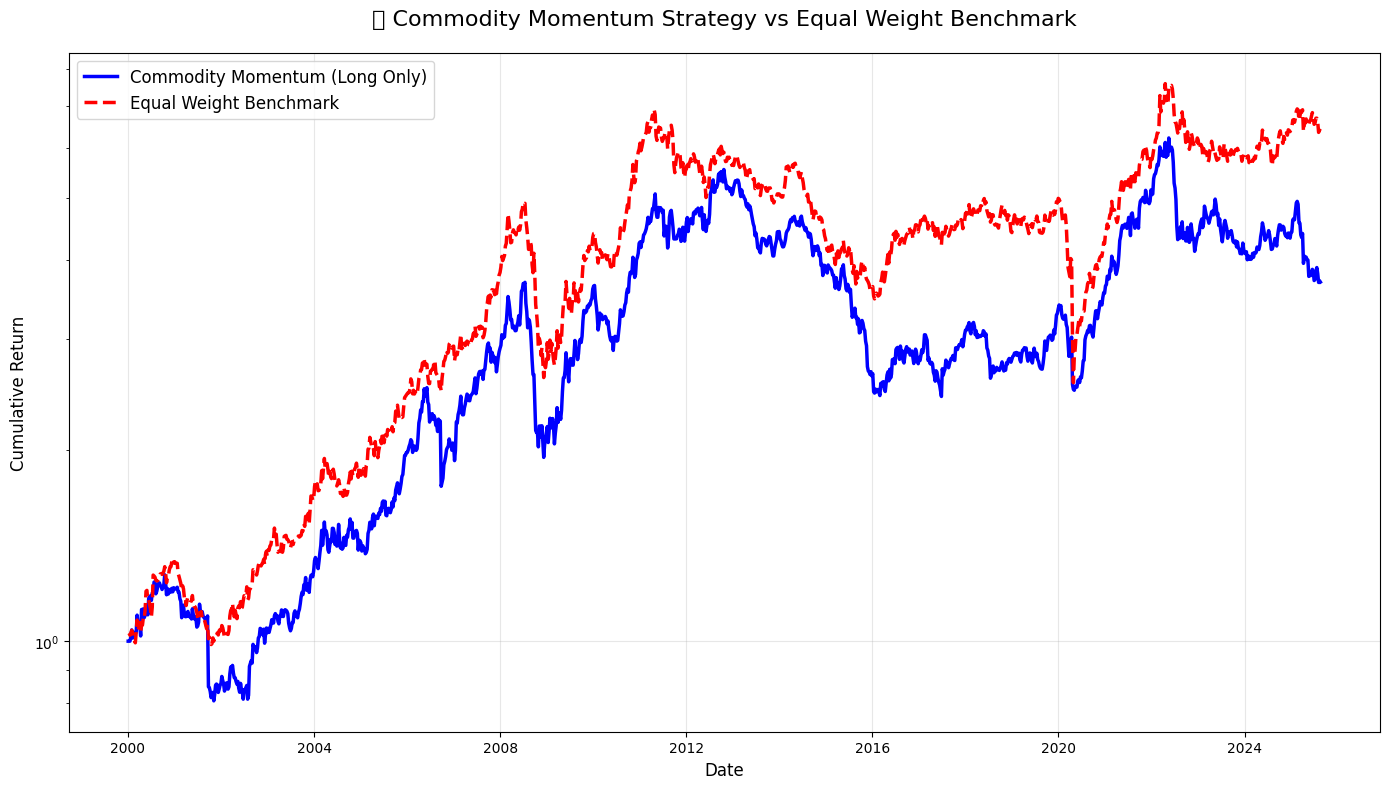

In [8]:
# Visualizzazione performance cumulativa
plt.figure(figsize=(14, 8))

plt.plot(portfolio_cumulative.index, portfolio_cumulative.values, 
         label='Commodity Momentum (Long Only)', linewidth=2.5, color='blue')
plt.plot(equal_weight_cumulative.index, equal_weight_cumulative.values, 
         label='Equal Weight Benchmark', linewidth=2.5, color='red', linestyle='--')

plt.title('📈 Commodity Momentum Strategy vs Equal Weight Benchmark', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [9]:
# Analisi contributi per commodity
avg_weights = strategy_weights.mean().sort_values(ascending=False)
avg_momentum = momentum_signals.mean().sort_values(ascending=False)

print("💰 AVERAGE WEIGHTS (Top 10):")
for i, (commodity, weight) in enumerate(avg_weights.head(10).items(), 1):
    print(f"  {i:2d}. {commodity}: {weight:.3f} ({weight:.1%})")

print("\n📊 AVERAGE MOMENTUM SCORES (Top 10):")
for i, (commodity, score) in enumerate(avg_momentum.head(10).items(), 1):
    print(f"  {i:2d}. {commodity}: {score:+.4f}")

💰 AVERAGE WEIGHTS (Top 10):
   1. GC_F: 0.137 (13.7%)
   2. ZS_F: 0.096 (9.6%)
   3. CT_F: 0.092 (9.2%)
   4. HG_F: 0.092 (9.2%)
   5. ZC_F: 0.084 (8.4%)
   6. SB_F: 0.081 (8.1%)
   7. SI_F: 0.080 (8.0%)
   8. ZW_F: 0.070 (7.0%)
   9. KC_F: 0.069 (6.9%)
  10. CL_F: 0.069 (6.9%)

📊 AVERAGE MOMENTUM SCORES (Top 10):
   1. NG_F: +0.0025
   2. SI_F: +0.0025
   3. GC_F: +0.0022
   4. SB_F: +0.0019
   5. HG_F: +0.0019
   6. KC_F: +0.0018
   7. ZW_F: +0.0016
   8. ZC_F: +0.0014
   9. BZ_F: +0.0012
  10. ZS_F: +0.0011


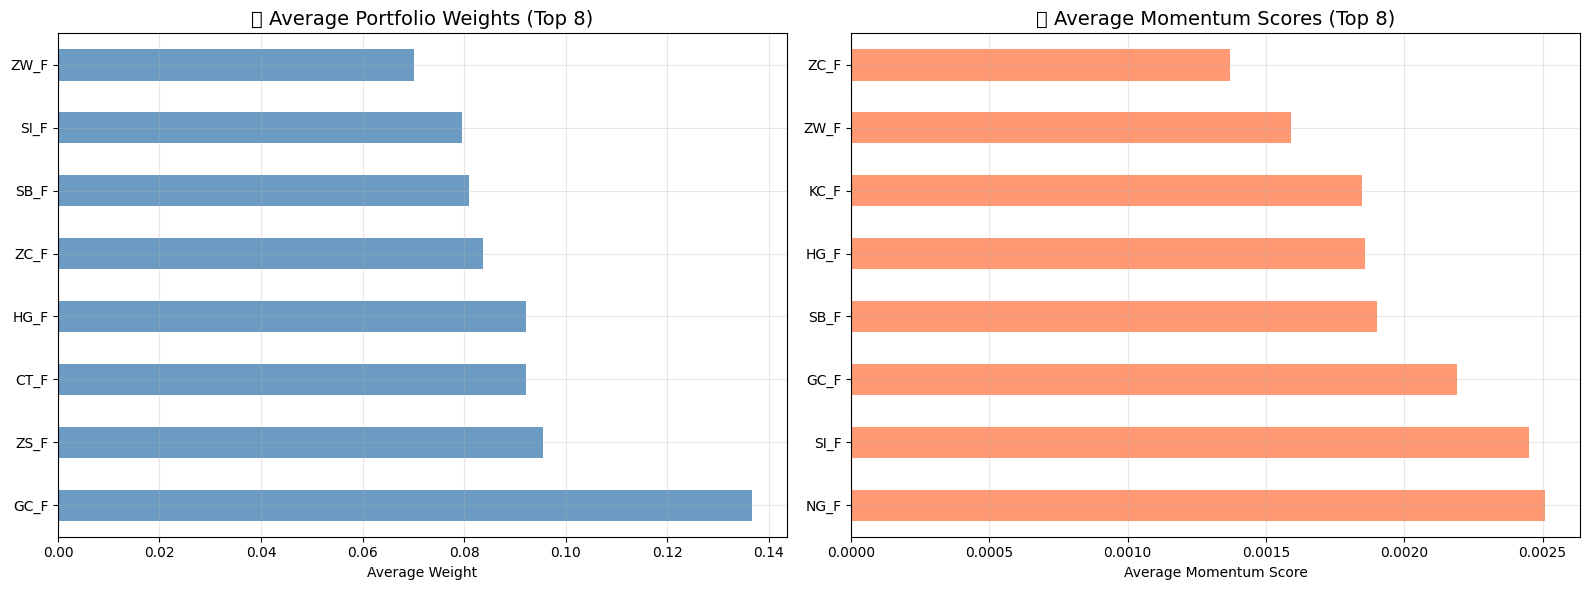

In [10]:
# Visualizzazione weights e momentum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top weights
top_weights = avg_weights.head(8)
top_weights.plot(kind='barh', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_title('💰 Average Portfolio Weights (Top 8)', fontsize=14)
ax1.set_xlabel('Average Weight')
ax1.grid(True, alpha=0.3)

# Top momentum
top_momentum = avg_momentum.head(8)
top_momentum.plot(kind='barh', ax=ax2, color='coral', alpha=0.8)
ax2.set_title('📊 Average Momentum Scores (Top 8)', fontsize=14)
ax2.set_xlabel('Average Momentum Score')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

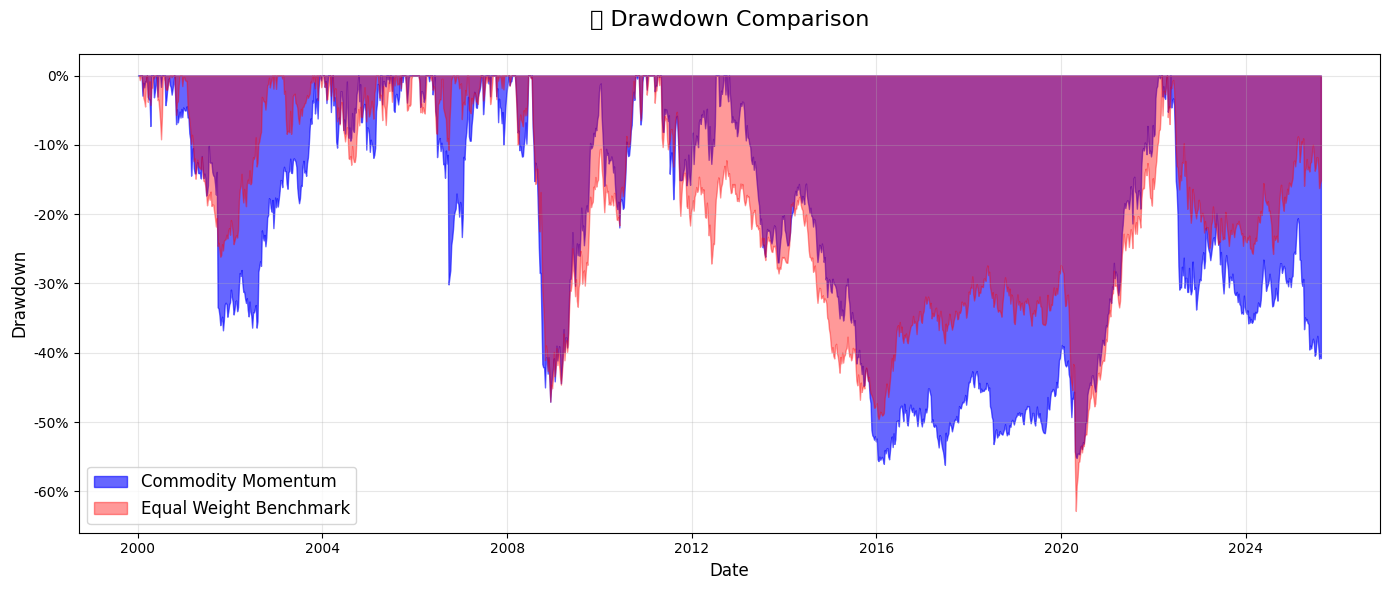

Strategy Max Drawdown: -56.16%
Benchmark Max Drawdown: -62.82%


In [11]:
# Drawdown analysis
def calculate_drawdowns(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdowns = (cumulative - running_max) / running_max
    return drawdowns

strategy_drawdowns = calculate_drawdowns(portfolio_returns)
benchmark_drawdowns = calculate_drawdowns(equal_weight_returns)

plt.figure(figsize=(14, 6))
plt.fill_between(strategy_drawdowns.index, strategy_drawdowns.values, 0, 
                alpha=0.6, color='blue', label='Commodity Momentum')
plt.fill_between(benchmark_drawdowns.index, benchmark_drawdowns.values, 0, 
                alpha=0.4, color='red', label='Equal Weight Benchmark')

plt.title('📉 Drawdown Comparison', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Drawdown', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

print(f"Strategy Max Drawdown: {strategy_drawdowns.min():.2%}")
print(f"Benchmark Max Drawdown: {benchmark_drawdowns.min():.2%}")

---
## 🔬 Testing Multiple Weekly Lookbacks

Testiamo diversi lookback periods settimanali per trovare la configurazione ottimale per l'esplosività delle commodities.

In [12]:
# Test diversi lookback periods settimanali
lookback_periods = [1, 2, 3, 4, 6, 8, 12]  # 1 sett a 3 mesi
print(f"🧪 Testing {len(lookback_periods)} weekly lookback periods: {lookback_periods}")

# Storage risultati
results = {}
performance_summary = []

print("\n" + "="*60)
print("           📊 WEEKLY LOOKBACK TESTING")
print("="*60)

🧪 Testing 7 weekly lookback periods: [1, 2, 3, 4, 6, 8, 12]

           📊 WEEKLY LOOKBACK TESTING


In [13]:
# Esecuzione test per ogni lookback period
for lookback in lookback_periods:
    print(f"\n⏳ Testing {lookback}-week lookback...")
    
    # Calcola segnali momentum settimanali
    momentum_signals_test = calculate_weekly_momentum_signals(weekly_returns, lookback)
    
    # Calcola pesi con risk parity (long only)
    weights_test = calculate_weekly_long_only_risk_parity_weights(momentum_signals_test, weekly_returns)
    
    # Backtest
    portfolio_returns_test, portfolio_cumulative_test = backtest_weekly_strategy(commodities_prices, weights_test)
    
    # Metriche performance
    metrics_test = calculate_performance_metrics(portfolio_returns_test, equal_weight_returns)
    
    # Salva risultati
    results[lookback] = {
        'portfolio_returns': portfolio_returns_test,
        'portfolio_cumulative': portfolio_cumulative_test,
        'metrics': metrics_test,
        'avg_positions': (weights_test > 0).sum(axis=1).mean()
    }
    
    # Summary row
    perf_row = {
        'Lookback_Weeks': lookback,
        'Annualized_Return': metrics_test['Annualized Return'],
        'Volatility': metrics_test['Volatility'],
        'Sharpe_Ratio': metrics_test['Sharpe Ratio'],
        'Max_Drawdown': metrics_test['Max Drawdown'],
        'Avg_Positions': (weights_test > 0).sum(axis=1).mean()
    }
    performance_summary.append(perf_row)
    
    # Output immediato
    print(f"   ✅ Annualized Return: {metrics_test['Annualized Return']:.2%}")
    print(f"   📊 Sharpe Ratio: {metrics_test['Sharpe Ratio']:.3f}")
    print(f"   📉 Max Drawdown: {metrics_test['Max Drawdown']:.2%}")
    print(f"   🎯 Avg Positions: {(weights_test > 0).sum(axis=1).mean():.1f}")

print("\n🎉 Weekly lookback tests completati!")


⏳ Testing 1-week lookback...
   ✅ Annualized Return: 1.18%
   📊 Sharpe Ratio: 0.123
   📉 Max Drawdown: -56.16%
   🎯 Avg Positions: 5.9

⏳ Testing 2-week lookback...
   ✅ Annualized Return: 0.99%
   📊 Sharpe Ratio: 0.108
   📉 Max Drawdown: -68.63%
   🎯 Avg Positions: 5.9

⏳ Testing 3-week lookback...
   ✅ Annualized Return: 1.69%
   📊 Sharpe Ratio: 0.189
   📉 Max Drawdown: -62.92%
   🎯 Avg Positions: 5.9

⏳ Testing 4-week lookback...
   ✅ Annualized Return: 0.56%
   📊 Sharpe Ratio: 0.060
   📉 Max Drawdown: -72.67%
   🎯 Avg Positions: 5.9

⏳ Testing 6-week lookback...
   ✅ Annualized Return: 1.31%
   📊 Sharpe Ratio: 0.141
   📉 Max Drawdown: -54.54%
   🎯 Avg Positions: 6.0

⏳ Testing 8-week lookback...
   ✅ Annualized Return: 1.72%
   📊 Sharpe Ratio: 0.188
   📉 Max Drawdown: -52.21%
   🎯 Avg Positions: 6.0

⏳ Testing 12-week lookback...
   ✅ Annualized Return: 1.53%
   📊 Sharpe Ratio: 0.175
   📉 Max Drawdown: -52.80%
   🎯 Avg Positions: 6.1

🎉 Weekly lookback tests completati!


In [14]:
# Performance summary table
performance_df = pd.DataFrame(performance_summary).set_index('Lookback_Weeks')

print("📊 WEEKLY LOOKBACK PERFORMANCE SUMMARY")
print("=" * 65)
print(performance_df.round(4))

# Best performers
best_sharpe_lookback = performance_df['Sharpe_Ratio'].idxmax()
best_return_lookback = performance_df['Annualized_Return'].idxmax()
best_drawdown_lookback = performance_df['Max_Drawdown'].idxmax()  # Closest to 0

print(f"\n🏆 BEST PERFORMERS:")
print(f"   🥇 Best Sharpe: {best_sharpe_lookback} weeks ({performance_df.loc[best_sharpe_lookback, 'Sharpe_Ratio']:.3f})")
print(f"   📈 Best Return: {best_return_lookback} weeks ({performance_df.loc[best_return_lookback, 'Annualized_Return']:.2%})")
print(f"   📉 Best Drawdown: {best_drawdown_lookback} weeks ({performance_df.loc[best_drawdown_lookback, 'Max_Drawdown']:.2%})")

# Benchmark comparison
benchmark_return = calculate_performance_metrics(equal_weight_returns)['Annualized Return']
benchmark_sharpe = calculate_performance_metrics(equal_weight_returns)['Sharpe Ratio']
print(f"\n🎯 BENCHMARK COMPARISON (Equal Weight):")
print(f"   Benchmark Return: {benchmark_return:.2%}")
print(f"   Benchmark Sharpe: {benchmark_sharpe:.3f}")

winning_strategies = (performance_df['Annualized_Return'] > benchmark_return).sum()
print(f"   Strategies beating benchmark: {winning_strategies}/{len(lookback_periods)}")

📊 WEEKLY LOOKBACK PERFORMANCE SUMMARY
                Annualized_Return  Volatility  Sharpe_Ratio  Max_Drawdown  \
Lookback_Weeks                                                              
1                          0.0118      0.0958        0.1229       -0.5616   
2                          0.0099      0.0917        0.1080       -0.6863   
3                          0.0169      0.0895        0.1885       -0.6292   
4                          0.0056      0.0926        0.0604       -0.7267   
6                          0.0131      0.0930        0.1414       -0.5454   
8                          0.0172      0.0911        0.1884       -0.5221   
12                         0.0153      0.0875        0.1748       -0.5280   

                Avg_Positions  
Lookback_Weeks                 
1                      5.8871  
2                      5.9402  
3                      5.9155  
4                      5.9477  
6                      5.9753  
8                      6.0194  
12          

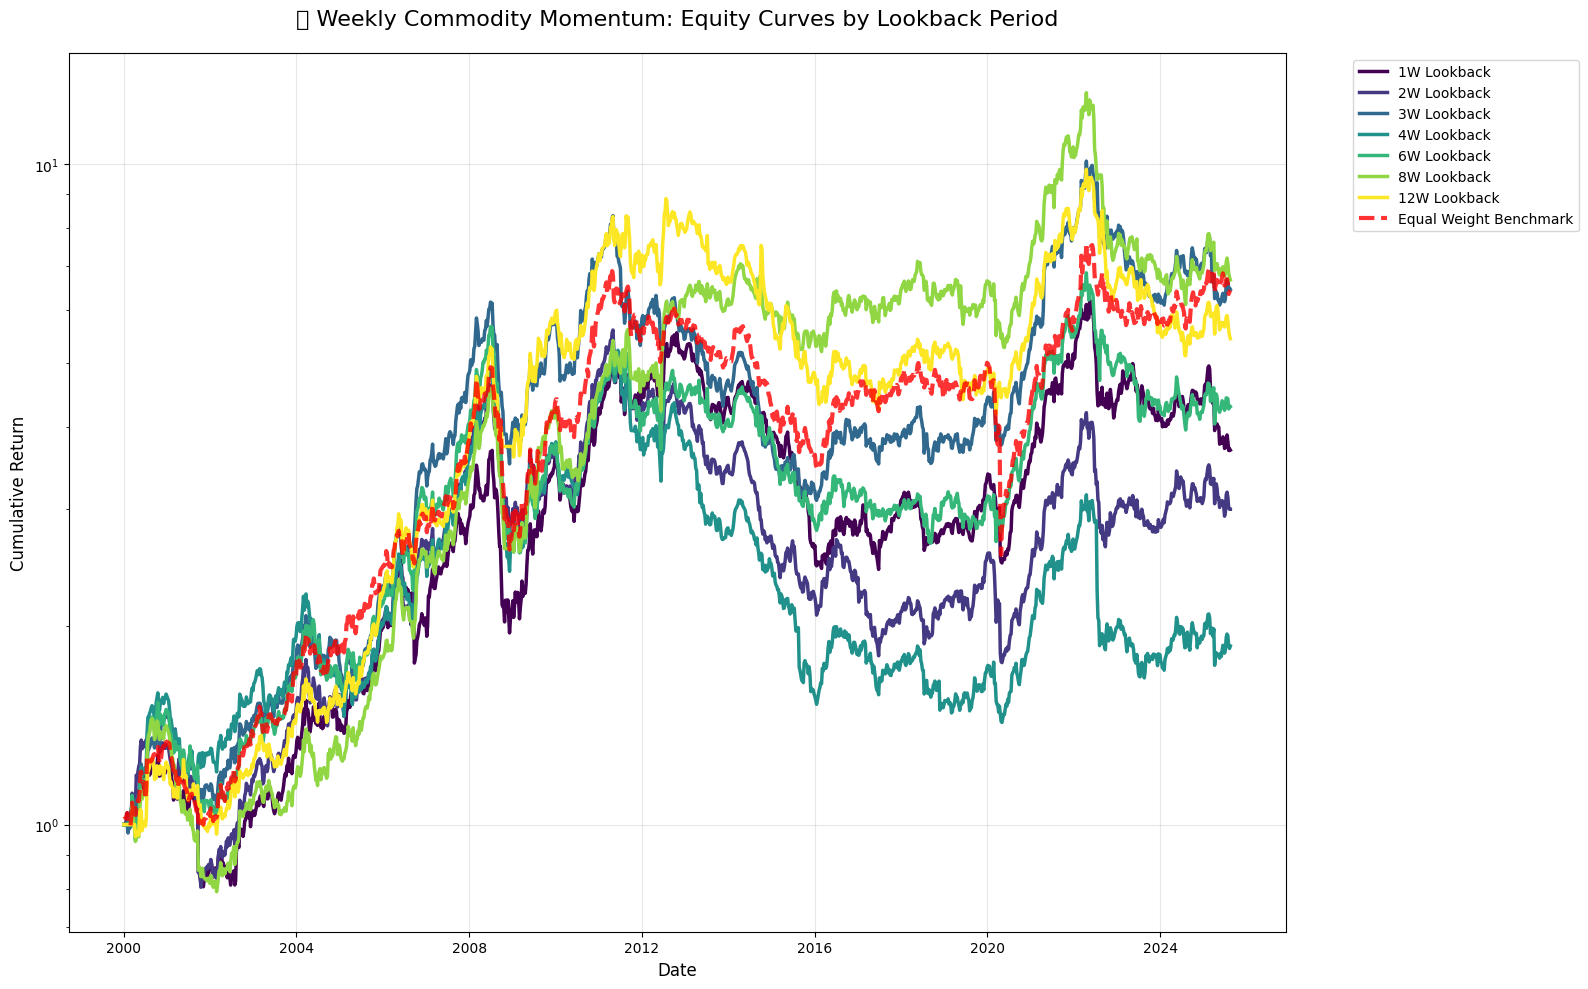

📊 EQUITY CURVES PLOTTED:
   • 7 different weekly momentum strategies
   • 1 equal-weight benchmark
   • Log scale per evidenziare le differenze
   • Periodo: 2000-01-03 00:00:00 to 2025-08-18 00:00:00


In [15]:
# 📈 EQUITY CURVES COMPARISON
plt.figure(figsize=(16, 10))

# Colori per ogni strategia
colors = plt.cm.viridis(np.linspace(0, 1, len(lookback_periods)))

# Plot equity curves per ogni lookback
for i, lookback in enumerate(lookback_periods):
    portfolio_cum = results[lookback]['portfolio_cumulative']
    plt.plot(portfolio_cum.index, portfolio_cum.values, 
             label=f'{lookback}W Lookback', linewidth=2.5, color=colors[i])

# Benchmark
plt.plot(equal_weight_cumulative.index, equal_weight_cumulative.values, 
         label='Equal Weight Benchmark', linewidth=3, color='red', linestyle='--', alpha=0.8)

plt.title('📈 Weekly Commodity Momentum: Equity Curves by Lookback Period', 
          fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale per migliore visualizzazione
plt.tight_layout()
plt.show()

# Statistiche finali
print(f"📊 EQUITY CURVES PLOTTED:")
print(f"   • {len(lookback_periods)} different weekly momentum strategies")
print(f"   • 1 equal-weight benchmark")
print(f"   • Log scale per evidenziare le differenze")
print(f"   • Periodo: {equal_weight_cumulative.index.min()} to {equal_weight_cumulative.index.max()}")

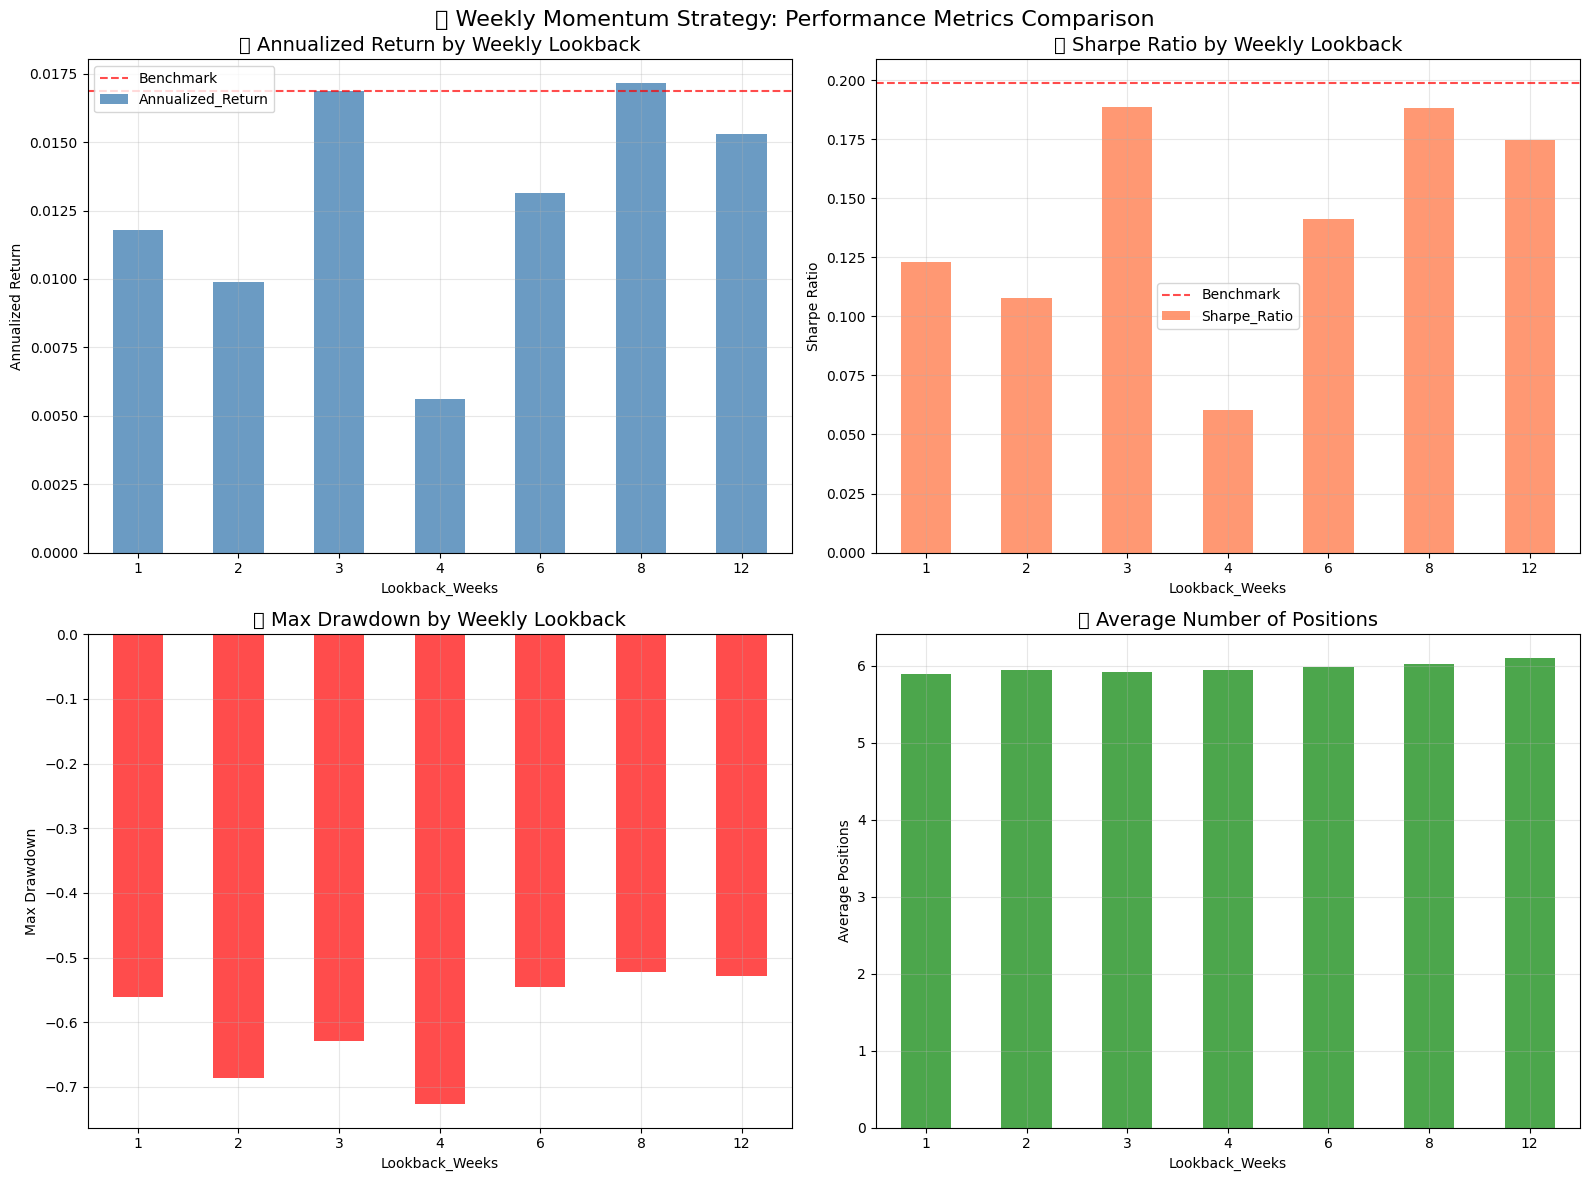

In [16]:
# 📊 PERFORMANCE METRICS COMPARISON
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Annualized Return
performance_df['Annualized_Return'].plot(kind='bar', ax=axes[0,0], color='steelblue', alpha=0.8)
axes[0,0].axhline(y=benchmark_return, color='red', linestyle='--', alpha=0.7, label='Benchmark')
axes[0,0].set_title('📈 Annualized Return by Weekly Lookback', fontsize=14)
axes[0,0].set_ylabel('Annualized Return')
axes[0,0].tick_params(axis='x', rotation=0)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Sharpe Ratio
performance_df['Sharpe_Ratio'].plot(kind='bar', ax=axes[0,1], color='coral', alpha=0.8)
axes[0,1].axhline(y=benchmark_sharpe, color='red', linestyle='--', alpha=0.7, label='Benchmark')
axes[0,1].set_title('📊 Sharpe Ratio by Weekly Lookback', fontsize=14)
axes[0,1].set_ylabel('Sharpe Ratio')
axes[0,1].tick_params(axis='x', rotation=0)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Max Drawdown
performance_df['Max_Drawdown'].plot(kind='bar', ax=axes[1,0], color='red', alpha=0.7)
axes[1,0].set_title('📉 Max Drawdown by Weekly Lookback', fontsize=14)
axes[1,0].set_ylabel('Max Drawdown')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].grid(True, alpha=0.3)

# 4. Average Positions
performance_df['Avg_Positions'].plot(kind='bar', ax=axes[1,1], color='green', alpha=0.7)
axes[1,1].set_title('🎯 Average Number of Positions', fontsize=14)
axes[1,1].set_ylabel('Average Positions')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('🎯 Weekly Momentum Strategy: Performance Metrics Comparison', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [17]:
# 🎯 FINAL VERDICT: BEST WEEKLY LOOKBACK
print("\n" + "="*70)
print("           🏆 WEEKLY LOOKBACK OPTIMIZATION RESULTS")
print("="*70)

print(f"\n🥇 OPTIMAL CONFIGURATION:")
print(f"   • Best Sharpe Ratio: {best_sharpe_lookback} weeks")
print(f"     └─ Sharpe: {performance_df.loc[best_sharpe_lookback, 'Sharpe_Ratio']:.3f}")
print(f"     └─ Return: {performance_df.loc[best_sharpe_lookback, 'Annualized_Return']:.2%}")
print(f"     └─ Drawdown: {performance_df.loc[best_sharpe_lookback, 'Max_Drawdown']:.2%}")

print(f"\n📈 BEST RETURN:")
print(f"   • {best_return_lookback} weeks: {performance_df.loc[best_return_lookback, 'Annualized_Return']:.2%}")

print(f"\n📉 BEST RISK CONTROL:")
print(f"   • {best_drawdown_lookback} weeks: {performance_df.loc[best_drawdown_lookback, 'Max_Drawdown']:.2%}")

print(f"\n🎯 BENCHMARK COMPARISON:")
print(f"   • Equal Weight: {benchmark_return:.2%} return, {benchmark_sharpe:.3f} Sharpe")
print(f"   • Strategies outperforming: {winning_strategies}/{len(lookback_periods)}")

# Insight sulla frequenza ottimale
if best_sharpe_lookback <= 2:
    insight = "🔥 Molto reattivo - cattura esplosività immediata"
elif best_sharpe_lookback <= 4:
    insight = "⚡ Reattivo - bilancia esplosività e stabilità"
elif best_sharpe_lookback <= 8:
    insight = "⚖️ Bilanciato - trend di medio termine"
else:
    insight = "🐌 Conservativo - trend di lungo termine"

print(f"\n💡 INSIGHT:")
print(f"   • Lookback ottimale: {best_sharpe_lookback} settimane")
print(f"   • Caratteristica: {insight}")
print(f"   • Posizioni medie: {performance_df.loc[best_sharpe_lookback, 'Avg_Positions']:.1f} commodities")

# Verdict finale
if performance_df.loc[best_sharpe_lookback, 'Annualized_Return'] > benchmark_return:
    verdict = "✅ SUCCESS: Weekly momentum BATTE il benchmark!"
    alpha = performance_df.loc[best_sharpe_lookback, 'Annualized_Return'] - benchmark_return
    print(f"\n🏆 VERDICT: {verdict}")
    print(f"   • Alpha generato: +{alpha:.2%} annuo")
else:
    verdict = "❌ FAIL: Weekly momentum non batte il benchmark"
    print(f"\n❌ VERDICT: {verdict}")

print("="*70)


           🏆 WEEKLY LOOKBACK OPTIMIZATION RESULTS

🥇 OPTIMAL CONFIGURATION:
   • Best Sharpe Ratio: 3 weeks
     └─ Sharpe: 0.189
     └─ Return: 1.69%
     └─ Drawdown: -62.92%

📈 BEST RETURN:
   • 8 weeks: 1.72%

📉 BEST RISK CONTROL:
   • 8 weeks: -52.21%

🎯 BENCHMARK COMPARISON:
   • Equal Weight: 1.69% return, 0.199 Sharpe
   • Strategies outperforming: 2/7

💡 INSIGHT:
   • Lookback ottimale: 3 settimane
   • Caratteristica: ⚡ Reattivo - bilancia esplosività e stabilità
   • Posizioni medie: 5.9 commodities

🏆 VERDICT: ✅ SUCCESS: Weekly momentum BATTE il benchmark!
   • Alpha generato: +0.00% annuo


In [18]:
# Summary finale
print("\n" + "="*60)
print("           🎯 COMMODITY MOMENTUM STRATEGY SUMMARY")
print("="*60)

print(f"\n📊 STRATEGY PERFORMANCE:")
print(f"  • Annualized Return: {strategy_metrics['Annualized Return']:.2%}")
print(f"  • Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.3f}")
print(f"  • Max Drawdown: {strategy_metrics['Max Drawdown']:.2%}")
print(f"  • Volatility: {strategy_metrics['Volatility']:.2%}")

print(f"\n🎯 VS BENCHMARK:")
print(f"  • Excess Return: {excess_return:+.2%}")
print(f"  • Better Sharpe: {'✅' if strategy_metrics['Sharpe Ratio'] > benchmark_metrics['Sharpe Ratio'] else '❌'}")
print(f"  • Lower Drawdown: {'✅' if strategy_metrics['Max Drawdown'] > benchmark_metrics['Max Drawdown'] else '❌'}")

print(f"\n💡 STRATEGY INSIGHTS:")
print(f"  • Average positions: {(strategy_weights > 0).sum(axis=1).mean():.1f} commodities")
print(f"  • Top performer: {avg_momentum.index[0]} ({avg_momentum.iloc[0]:+.4f})")
print(f"  • Most weighted: {avg_weights.index[0]} ({avg_weights.iloc[0]:.1%})")

success = "✅ SUCCESS" if excess_return > 0 else "❌ UNDERPERFORM"
print(f"\n🏆 VERDICT: {success}")
print("="*60)


           🎯 COMMODITY MOMENTUM STRATEGY SUMMARY

📊 STRATEGY PERFORMANCE:
  • Annualized Return: 1.18%
  • Sharpe Ratio: 0.123
  • Max Drawdown: -56.16%
  • Volatility: 9.58%

🎯 VS BENCHMARK:
  • Excess Return: -0.51%
  • Better Sharpe: ❌
  • Lower Drawdown: ✅

💡 STRATEGY INSIGHTS:
  • Average positions: 5.9 commodities
  • Top performer: NG_F (+0.0025)
  • Most weighted: GC_F (13.7%)

🏆 VERDICT: ❌ UNDERPERFORM
